In [165]:
import dare
import random
import time
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from SISA_lib import SISA

In [166]:
data = pd.read_csv("cleaned_loan.csv")
data

,Pekerjaan,Jenis Pinjaman,Plafon (Rp.),Kondisi Joint Income,Kondisi Pisah Harta,Usia,Hasil IDEB SLIK OJK,Tujuan Pemilikan Properti,Lama bekerja,Penghasilan,...,Down Payment,Asset lainnya yang dimiliki,Bidang Usaha,Ukuran Perusahaan,Kondisi Sertifikat Agunan Utama,Jenis Bangunan Utama,Kondisi Properti Utama,Keputusan,Kelayakan Dokumen Pendukung,Keputusan Akhir
0,KARYAWAN,"PEMBELIAN BEKAS / SECONDARY, RUMAH TINGGAL","Plafon (< 514,750,000)",TIDAK JOINT INCOME,TIDAK PISAH HARTA,21 - 35,Data Tidak Tersedia,Rumah Tinggal (Rumah ke 1),"≥ 2, < 5",SINGLE : ≥RP 10 JUTA,...,>= 15%,DEPOSITO/INVES/EMAS ≥ LIMIT KREDIT,"Keuangan, asuransi, perbankan",Cakupan area : nasional,"SHM, SERTIPIKAT PECAH",Rumah Tinggal,READY STOK,GREEN,LAYAK,Diterima
1,PENGUSAHA,"PEMBELIAN BEKAS / SECONDARY, RUMAH TINGGAL","Plafon (> 1,340,960,436)",TIDAK JOINT INCOME,PISAH HARTA,36 - 45,"Kol 1, Tidak pernah menunggak",Rumah Tinggal (Rumah ke 1),≥ 5,MENIKAH : ≥RP 20 JUTA,...,>= 15%,DEPOSITO/INVES/EMAS ≥ LIMIT KREDIT,Lainnya,Cakupan area : nasional,"SHM, SERTIPIKAT PECAH",Rumah Tinggal,READY STOK,GREEN,LAYAK,Diterima
2,KARYAWAN,"TAKE OVER + TOP UP KPR, RUMAH TINGGAL","Plafon (> 1,340,960,436)",JOINT INCOME,TIDAK PISAH HARTA,46 - 55,"Kol 1, Tidak pernah menunggak",Rumah Tinggal (Rumah ke 1),≥ 5,MENIKAH : ≥RP 20 JUTA,...,>= 15%,PROPERTI/KENDARAAN ≥ LIMIT KREDIT,KLINIK AKUPUNTIR,CAKUPAN AREA : LOKAL,"SHM, SERTIPIKAT PECAH",Rumah Tinggal,SEDANG DIHUNI,GREEN,LAYAK,Diterima
3,PENGUSAHA,"PEMBELIAN BEKAS / SECONDARY, RUMAH TINGGAL","Plafon (894,632,536 - 1,340,960,436)",JOINT INCOME,TIDAK PISAH HARTA,36 - 45,"Kol 1, Tidak pernah menunggak",RUMAH TINGGAL (RUMAH KE 2/3),≥ 5,MENIKAH : ≥RP 20 JUTA,...,>= 15%,PROPERTI/KENDARAAN < 100% LIMIT KREDIT,PERDAGANGAN,CAKUPAN AREA : LOKAL,"SHM, SERTIPIKAT PECAH",RUKO/RUKAN,READY STOK,GREEN,LAYAK,Diterima
4,KARYAWAN,"PEMBELIAN BEKAS / SECONDARY, RUMAH TINGGAL","Plafon (< 514,750,000)",JOINT INCOME,TIDAK PISAH HARTA,21 - 35,Data Tidak Tersedia,Rumah Tinggal (Rumah ke 1),"≥ 2, < 5","SINGLE : ≥RP 6 JUTA, < RP. 10 JUTA",...,>= 15%,KAS DAN NON KAS ≥ LIMIT KREDIT,COLOUR SALON,CAKUPAN AREA : LOKAL,"SHGB, SERTIPIKAT PECAH",Rumah Tinggal,SEDANG DIHUNI,YELLOW,LAYAK,Diterima
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,KARYAWAN,"Pembelian Baru / Primary, Rumah Tinggal > Tipe 70","Plafon (> 1,340,960,436)",TIDAK JOINT INCOME,TIDAK PISAH HARTA,21 - 35,"Kol 1, Tidak pernah menunggak",Rumah Tinggal (Rumah ke 1),"≥ 2, < 5",SINGLE : ≥RP 20 JUTA,...,>= 15%,Properti/kendaraan < 50% plafon,"INFORMASI, TELEKOMUNIKASI DAN KOMPUTER",Public listed,MOU - Sertipikat Induk,Rumah Tinggal,Indent,YELLOW,TIDAK,Ditolak
196,KARYAWAN,"Pembelian Baru / Primary, Rumah Tinggal Tipe 2...","Plafon (< 514,750,000)",JOINT INCOME,TIDAK PISAH HARTA,21 - 35,Data Tidak Tersedia,Rumah Tinggal (Rumah ke 1),≥ 5,"MENIKAH : ≥RP 10 JUTA, <RP 20 JUTA",...,>= 15%,DEPOSITO/INVES/EMAS < 50% plafon,Lainnya,Multinasional,"SHGB, SERTIPIKAT PECAH",Rumah Tinggal,Indent,GREEN,TIDAK,Ditolak
197,KARYAWAN,"Pembelian Baru / Primary, Rumah Tinggal Tipe 2...","Plafon (< 514,750,000)",TIDAK JOINT INCOME,TIDAK PISAH HARTA,21 - 35,"Kol 1, Tidak pernah menunggak",Rumah Tinggal (Rumah ke 1),"≥ 2, < 5","SINGLE : ≥RP 6 JUTA, < RP. 10 JUTA",...,>= 15%,DEPOSITO/INVES/EMAS < 50% plafon,Lainnya,CAKUPAN AREA : LOKAL,MOU - Sertipikat Induk,Rumah Tinggal,Indent,YELLOW,TIDAK,Ditolak
198,PENGUSAHA,"Pembelian Baru / Primary, Ruko / Rukan","Plafon (> 1,340,960,436)",TIDAK JOINT INCOME,PISAH HARTA,56 - 65,"Kol 1, Tidak pernah menunggak",Rumah Tinggal (Rumah ke 1),≥ 5,MENIKAH : ≥RP 20 JUTA,...,>= 15%,null < 50% plafon,Lainnya,Multinasional,MOU - Sertipikat Induk,RUKO/RUKAN,Indent,GREEN,TIDAK,Ditolak


In [167]:
labelEncoder = {}
for col in data.columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    labelEncoder[col] = le
data

,Pekerjaan,Jenis Pinjaman,Plafon (Rp.),Kondisi Joint Income,Kondisi Pisah Harta,Usia,Hasil IDEB SLIK OJK,Tujuan Pemilikan Properti,Lama bekerja,Penghasilan,...,Down Payment,Asset lainnya yang dimiliki,Bidang Usaha,Ukuran Perusahaan,Kondisi Sertifikat Agunan Utama,Jenis Bangunan Utama,Kondisi Properti Utama,Keputusan,Kelayakan Dokumen Pendukung,Keputusan Akhir
0,0,1,2,1,1,0,0,2,1,5,...,1,2,14,1,6,2,1,0,0,0
1,1,1,3,1,0,1,8,2,2,3,...,1,2,15,1,6,2,1,0,0,0
2,0,9,3,0,1,2,8,2,2,3,...,1,9,12,0,6,2,2,0,0,0
3,1,1,1,0,1,1,8,1,2,3,...,1,7,19,0,6,1,1,0,0,0
4,0,1,2,0,1,0,0,2,1,8,...,1,5,2,0,3,2,2,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0,6,3,1,1,0,8,2,1,7,...,1,10,6,4,0,2,0,2,1,1
196,0,7,2,0,1,0,0,2,2,2,...,1,1,15,3,3,2,0,0,1,1
197,0,7,2,1,1,0,8,2,1,8,...,1,1,15,0,0,2,0,2,1,1
198,1,5,3,1,0,3,8,2,2,3,...,1,12,15,3,0,1,0,0,1,1


In [168]:
data = data.drop_duplicates()
data

,Pekerjaan,Jenis Pinjaman,Plafon (Rp.),Kondisi Joint Income,Kondisi Pisah Harta,Usia,Hasil IDEB SLIK OJK,Tujuan Pemilikan Properti,Lama bekerja,Penghasilan,...,Down Payment,Asset lainnya yang dimiliki,Bidang Usaha,Ukuran Perusahaan,Kondisi Sertifikat Agunan Utama,Jenis Bangunan Utama,Kondisi Properti Utama,Keputusan,Kelayakan Dokumen Pendukung,Keputusan Akhir
0,0,1,2,1,1,0,0,2,1,5,...,1,2,14,1,6,2,1,0,0,0
1,1,1,3,1,0,1,8,2,2,3,...,1,2,15,1,6,2,1,0,0,0
2,0,9,3,0,1,2,8,2,2,3,...,1,9,12,0,6,2,2,0,0,0
3,1,1,1,0,1,1,8,1,2,3,...,1,7,19,0,6,1,1,0,0,0
4,0,1,2,0,1,0,0,2,1,8,...,1,5,2,0,3,2,2,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0,6,3,1,1,0,8,2,1,7,...,1,10,6,4,0,2,0,2,1,1
196,0,7,2,0,1,0,0,2,2,2,...,1,1,15,3,3,2,0,0,1,1
197,0,7,2,1,1,0,8,2,1,8,...,1,1,15,0,0,2,0,2,1,1
198,1,5,3,1,0,3,8,2,2,3,...,1,12,15,3,0,1,0,0,1,1


In [169]:
X = data.drop(["Keputusan Akhir"], axis=1)
y = data["Keputusan Akhir"]

In [170]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [171]:
X_train_base = X_train.copy()
y_train_base = y_train.copy()
X_test_base = X_test.copy()

In [172]:
#SISA train and test dataset formats
X_train_SISA = X_train.values
y_train_SISA = y_train.values
X_test_SISA = X_test.values

In [173]:
#DaRE Forest train dataset
X_train_dare = np.array(X_train.values.tolist())
y_train_dare = np.array(y_train.values.tolist())
X_test_dare = np.array(X_test.values.tolist())

In [174]:
#make model for each machine learning model

In [175]:
#Base Model using RandomForest
tree_model = RandomForestClassifier(n_estimators=50,max_depth=5, random_state=42)
tree_model.fit(X_train_base, y_train_base)

RandomForestClassifier(max_depth=5, n_estimators=50, random_state=42)

In [176]:
#predict using XGBoost model
y_pred_tree = tree_model.predict(X_test_base)
accuracy_tree = accuracy_score(y_pred_tree, y_test)
print(f"Akurasi Model Decision Tree : {accuracy_tree}")

Akurasi Model Decision Tree : 0.9444444444444444


In [177]:
#SISA Model akurasi by shard
shard = 2
accuracy = 1
exp_results = pd.DataFrame(columns=['Shard', 'Accuracy'])

In [178]:
while accuracy > 0.90:
    sisa_by_shard = SISA(shard)
    sisa_by_shard .train(X_train_SISA, y_train_SISA)
    y_pred = sisa_by_shard .predict(X_test_SISA)
    accuracy = accuracy_score(y_pred, y_test)
    exp_results = pd.concat([exp_results, pd.DataFrame([{'Shard': shard, 'Accuracy': accuracy}])], ignore_index=True)
    shard += 1

In [179]:
#show sisa accuracy by shard
data_result = pd.DataFrame(exp_results)
data_result

,Shard,Accuracy
0,2,0.944444
1,3,0.944444
2,4,0.972222
3,5,0.944444
4,6,0.888889


In [180]:
#Base on result below, SISA model will use 4 shard for expriment
sisa = SISA(4)
sisa.train(X_train_SISA, y_train_SISA)

In [181]:
y_pred_SISA = sisa.predict(X_test_SISA)
accuracy_SISA = accuracy_score(y_pred_SISA, y_test)
print(f"Akurasi Model SISA : {accuracy_SISA}")

Akurasi Model SISA : 0.9722222222222222


In [182]:
#DaRE Forest Model
dafo = dare.Forest(n_estimators=50, max_depth=5, k = 5, topd = 0, random_state=42)
dafo.fit(X_train_dare, y_train_dare)

In [183]:
#Predict using DaRE Forest Model
y_pred_dare = dafo.predict(X_test_dare)
accuracy_dare = accuracy_score(y_pred_dare, y_test)
print(f"Akurasi Model DaRE Forest : {accuracy_dare}")

Akurasi Model DaRE Forest : 0.9444444444444444


In [184]:
#Perbandingan label untuk masing-masing model

#### Melakukan proses penghapusan secara random untuk masing-masing model

In [185]:
#Create dataFrame for each model
base_model = pd.DataFrame(columns=['Jumlah data', 'Accuracy', 'Time'])
SISA_model = pd.DataFrame(columns=['Jumlah data', 'Accuracy', 'Time'])
dare_model = pd.DataFrame(columns=['Jumlah data', 'Accuracy', 'Time'])
comparition_model = pd.DataFrame(columns=['Proporsi penghapusan', 'Random Forest', 'Accuracy SISA', 'Accuracy DaRE','Time Base', 'Time SISA', 'Time DaRE'])
y_pred_comparition = pd.DataFrame(columns=['Proporsi penghapusan', 'Random Forest - SISA', 'Random Forest - DaRE Forest'])

In [186]:
#Create function to delete base model data
def delete_base_data(X_train_base, y_train_base, index): 
    X_data = X_train.iloc[index].tolist()
    data_to_delete = X_train_base.apply(lambda row: all(elem in row.values for elem in X_data), axis=1)
    X_train_base = X_train_base[~data_to_delete]
    y_train_base = y_train_base[~data_to_delete]
    return X_train_base, y_train_base

In [187]:
#create variabel for process
deleted_index = []
jumlah_data = len(X_train)
max_random_number = len(X_train) - 1
y_pred_comparison_flag = 0
jumlah_data_hapus = 0

In [188]:
while len(deleted_index) < max_random_number:
    #get new index
    new_index = False
    while new_index == False:
        index = random.randint(0, max_random_number - 1)
        if index not in deleted_index:
            deleted_index.append(index)
            break
    jumlah_data -= 1
    jumlah_data_hapus +=1
    #Base Model with decreasing dataset
    try:
        start_time_base = time.time()
        X_train_base, y_train_base = delete_base_data(X_train_base, y_train_base,index)
        tree_model.fit(X_train_base, y_train_base)
        training_time_base = time.time() - start_time_base

        #prediction using base model with new data
        y_pred_tree = tree_model.predict(X_test_base)
        accuracy_tree = accuracy_score(y_pred_tree, y_test)

        #add to dataframe
        base_model = pd.concat([base_model, pd.DataFrame([{'Jumlah data': jumlah_data,'Accuracy': accuracy_tree, "Time" : training_time_base}])], ignore_index=True)
    except:
        print("Penghapusan data mencapai maksimal")
        break

    #delete elemen by sisa
    try:
        start_time_sisa = time.time()
        sisa.delete([X_train_SISA[index]])
        training_time_sisa = time.time() - start_time_sisa

        #prediction using model with deleted data
        y_pred_SISA = sisa.predict(X_test_SISA)
        accuracy_SISA = accuracy_score(y_pred_SISA, y_test)

        #add to dataframe
        SISA_model = pd.concat([SISA_model, pd.DataFrame([{'Jumlah data': jumlah_data,'Accuracy': accuracy_SISA, "Time" : training_time_sisa}])], ignore_index=True)
    except:
        print("salah satu data pada shard, sudah habis, silahkan train ulang model dari awal")
        # SISA_model = pd.concat([SISA_model, pd.DataFrame([{'Jumlah data': jumlah_data,'Accuracy': "-", "Time" : "-"}])], ignore_index=True)
        accuracy_SISA = 0
        training_time_sisa = 0
    
    #delete elemen by dareForest
    try:
        start_time_dare = time.time()
        dafo.delete(index)
        training_time_dare = time.time() - start_time_dare

        #prediction using model with deleted data
        y_pred_dare = dafo.predict(X_test_dare)
        accuracy_dare = accuracy_score(y_pred_dare, y_test)

        #add to dataframe
        dare_model = pd.concat([dare_model, pd.DataFrame([{'Jumlah data': jumlah_data,'Accuracy': accuracy_dare, "Time" : training_time_dare}])], ignore_index=True)
    except Exception as e:
        print(e)

    #comparisson model
    comparition_model = pd.concat([comparition_model, pd.DataFrame([{
        'Proporsi penghapusan' : round(jumlah_data_hapus/len(X_train),4),
        'Accuracy Base' : accuracy_tree,
        'Accuracy SISA' : accuracy_SISA,
        'Accuracy DaRE' : accuracy_dare,
        'Time Base' : training_time_base,
        'Time SISA' : training_time_sisa,
        'Time DaRE' : training_time_dare,
    }])], ignore_index=True)

    #compatison for y pred for each model
    #Random Forest and SISA Model
    base_sisa = np.sum(y_pred_tree == y_pred_SISA)
    base_sisa = round(base_sisa/len(y_pred_tree),2)
    #Random Forest and DaRE Forest model
    base_dare = np.sum(y_pred_tree == y_pred_dare)
    base_dare = round(base_dare/len(y_pred_tree),2)
    #Insert into dataframe
    y_pred_comparition = pd.concat([y_pred_comparition, pd.DataFrame([{
        'Proporsi penghapusan' : round(jumlah_data_hapus/len(X_train),4),
        'Random Forest - SISA' : base_sisa, 
        'Random Forest - DaRE Forest' : base_dare
    }])], ignore_index=True)

salah satu data pada shard, sudah habis, silahkan train ulang model dari awal
salah satu data pada shard, sudah habis, silahkan train ulang model dari awal
Penghapusan data mencapai maksimal


In [189]:
comparition_model.to_csv("hasil_eksperiment/exp_1/hasil_eksperiment_rev.csv", index=False)

In [190]:
y_pred_comparition.to_csv("hasil_eksperiment/exp_1/y_pred_compare_rev.csv", index=False)

In [191]:
import matplotlib.pyplot as plt

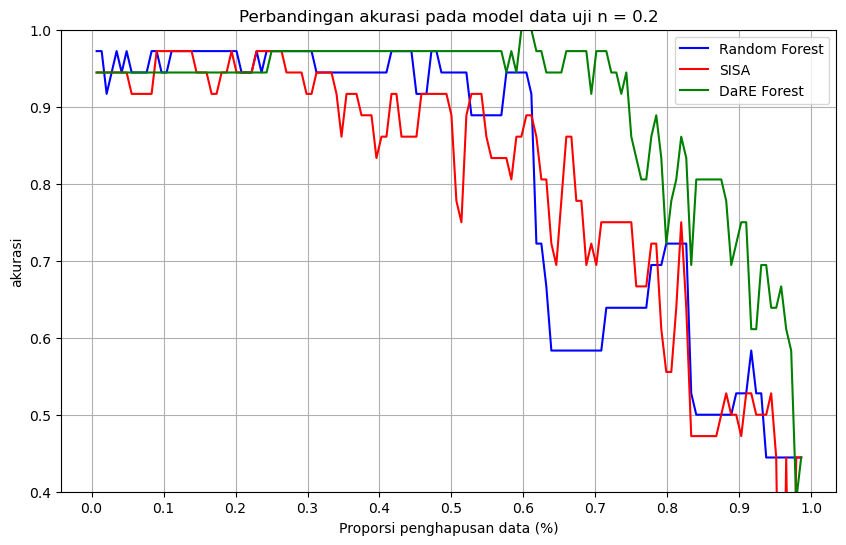

In [192]:
plt.figure(figsize=(10, 6))
plt.plot(comparition_model['Proporsi penghapusan'],comparition_model['Accuracy Base'], linestyle='-', color='blue', label='Random Forest')
plt.plot(comparition_model['Proporsi penghapusan'],comparition_model['Accuracy SISA'], linestyle='-', color='red', label='SISA' )
plt.plot(comparition_model['Proporsi penghapusan'],comparition_model['Accuracy DaRE'], linestyle='-', color='green', label='DaRE Forest')


plt.title("Perbandingan akurasi pada model data uji n = 0.2")
plt.xlabel("Proporsi penghapusan data (%)")
plt.ylabel("akurasi")
plt.legend()
plt.grid(True)
plt.ylim(0.4, 1)
plt.xticks(ticks=np.arange(0, 1.1, 0.1), labels=['0.0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9','1.0'])
plt.show()

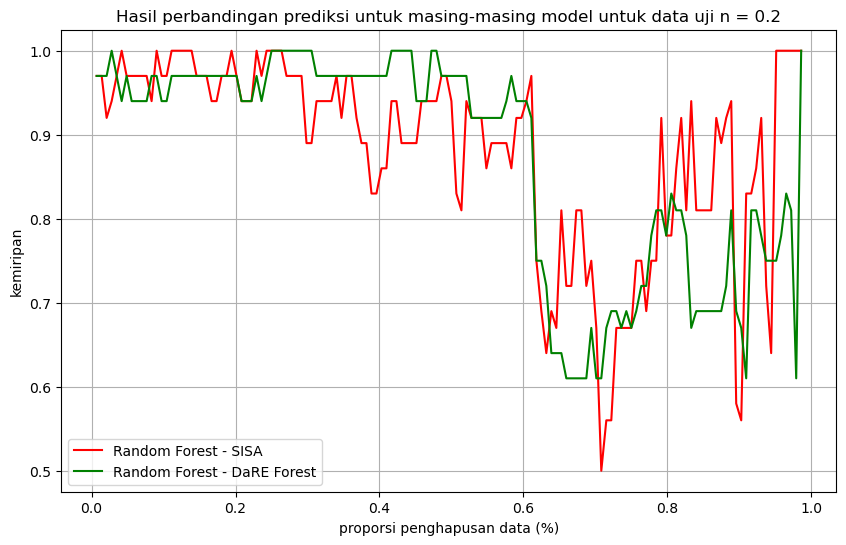

In [193]:
plt.figure(figsize=(10, 6))
plt.plot(y_pred_comparition['Proporsi penghapusan'], y_pred_comparition['Random Forest - SISA'], linestyle='-', color='red', label='Random Forest - SISA')
plt.plot(y_pred_comparition['Proporsi penghapusan'], y_pred_comparition['Random Forest - DaRE Forest'], linestyle='-', color='green', label='Random Forest - DaRE Forest')

plt.title("Hasil perbandingan prediksi untuk masing-masing model untuk data uji n = 0.2")
plt.xlabel("proporsi penghapusan data (%)")
plt.ylabel("kemiripan")
plt.legend()
plt.grid(True)
plt.show()